In [8]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10, 6)

db_con = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_test",
    user="hoarder",
    password="password")

In [5]:
 cids = pd.read_sql_query("""SELECT cid_hash FROM cid_info;""", db_con) 

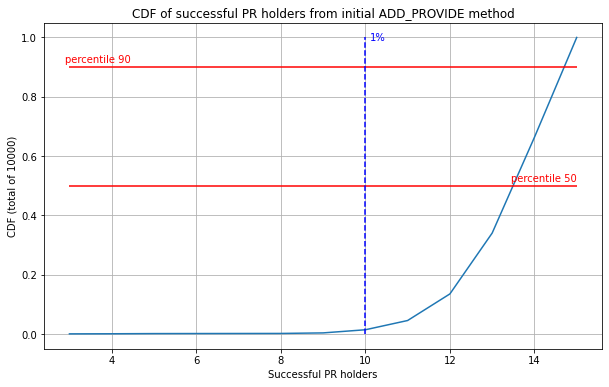

In [9]:
# Get the number of successfull ADD_PR 
pobj = pd.read_sql_query(f"""
select success_att, count(success_att) from fetch_results 
where ping_round=0 group by success_att order by success_att ASC""", db_con)

suc_cdf = np.cumsum(pobj['count'])
suc_cdf = suc_cdf/(suc_cdf[len(suc_cdf)-1])

per_1 = {'smalest_value': 0.0, 'x': 0.0}

for i, item in enumerate(suc_cdf):
    if item >= 0.01:
        per_1['smales_value'] = item
        per_1['x'] = pobj['success_att'][i]
        break


plt.plot(pobj["success_att"],suc_cdf)
plt.title("CDF of successful PR holders from initial ADD_PROVIDE method")
plt.xlabel("Successful PR holders")
plt.ylabel(f"CDF (total of {len(cids)})")

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['success_att'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['success_att']-0.1, 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.vlines(x=per_1['x'], ymin=0, ymax=1, linestyle='--', color='b')
plt.text(per_1['x']+0.1, 1, '1%', ha='left', va='center', color='b')

plt.grid()

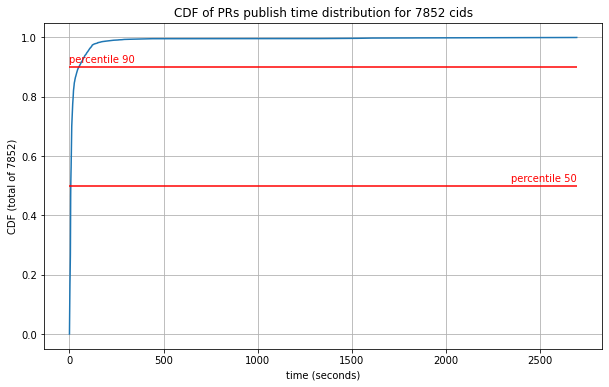

In [12]:
# TODO: Double check 

# Get the time to the IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time, count(provide_time) from cid_info group by provide_time order by provide_time ASC", db_con)
pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods


cdf_pt = np.cumsum(pobj['count'])
cdf_pt = cdf_pt / (cdf_pt[len(cdf_pt)-1])

plt.plot(pobj["provide_time"],cdf_pt)
plt.title(f'CDF of PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("time (seconds)")
plt.ylabel(f"CDF (total of {len(pobj)})")

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['provide_time'], 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.grid()

#plt.hist(pobj['provide_time'], cdf_pt)

Text(0, 0.5, 'Number of CIDs')

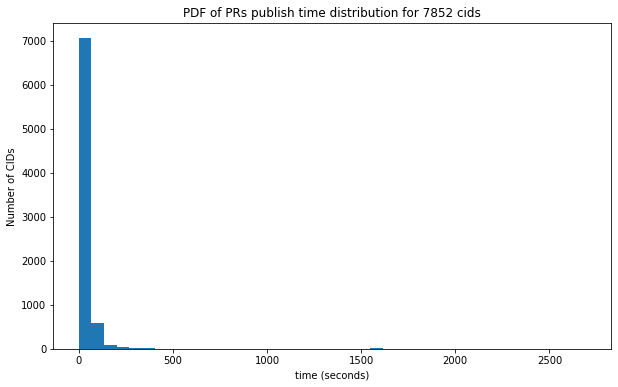

In [13]:
plt.hist(pobj['provide_time'], density=False, bins=40)
plt.title(f'PDF of PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("time (seconds)")
plt.ylabel(f"Number of CIDs")


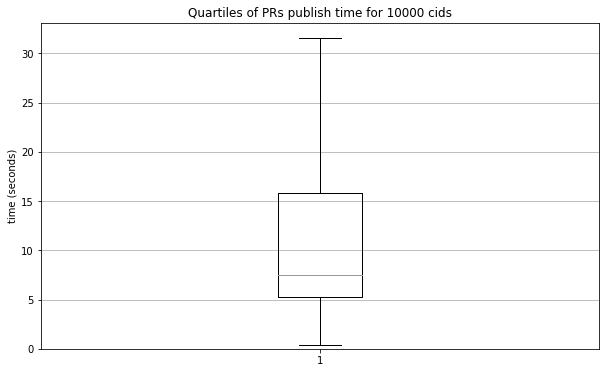

In [15]:
# Quartiles of time to execute IPFS DHT Provide method
pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", db_con)

pobj["provide_time"] /= 1000 # convert to secods 

fig, ax = plt.subplots()
ax.boxplot(pobj["provide_time"], showfliers=False)
ax.set_ylabel("time (seconds)")
ax.set_ylim(bottom=0) #, top=pobj.iloc[len(pobj)-1]
plt.title(f'Quartiles of PRs publish time for {len(pobj)} cids')
plt.grid(axis='y')

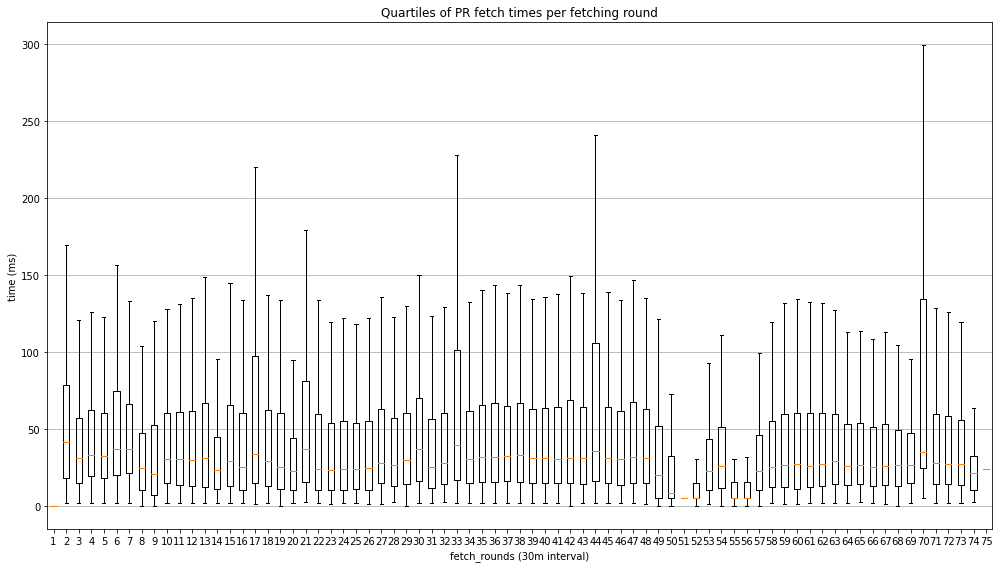

In [16]:
# Get the time to ping PR Holders

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)

fetch_time_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    fpd_round_ftime = pd.read_sql_query(f'select fetch_duration from fetch_results where ping_round={row["ping_round"]}', db_con) 
    fetch_time_dist.append(fpd_round_ftime['fetch_duration'] / 1000 ) # convert to secs

# TODO: remove zeros? 
    
fig, ax = plt.subplots()
ax.boxplot(fetch_time_dist, showfliers=False) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins?
ax.set_ylabel("time (ms)")
ax.figure.set_size_inches(14, 8)
plt.title("Quartiles of PR fetch times per fetching round")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [18]:
"""
# Get active PR holders over fetch rounds (just for double check following distributions)

# Get the number of rounds that we hoarded
pobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)

succ_att_dist = []
# Get the distribution for each of the rounds
for i, row in pobj.iterrows():
    p = pd.read_sql_query(f'select success_att from fetch_results where ping_round={row["ping_round"]}', db_con) 
    succ_att_dist.append(p['success_att'])

fig, ax = plt.subplots()
ax.boxplot(succ_att_dist, showfliers=True) 
ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
ax.set_ylabel("active PR holders")
ax.figure.set_size_inches(14, 8)
plt.title(f"Quartiles of active PR holders over fetching rounds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
"""

'\n# Get active PR holders over fetch rounds (just for double check following distributions)\n\n# Get the number of rounds that we hoarded\npobj = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", db_con)\n\nsucc_att_dist = []\n# Get the distribution for each of the rounds\nfor i, row in pobj.iterrows():\n    p = pd.read_sql_query(f\'select success_att from fetch_results where ping_round={row["ping_round"]}\', db_con) \n    succ_att_dist.append(p[\'success_att\'])\n\nfig, ax = plt.subplots()\nax.boxplot(succ_att_dist, showfliers=True) \nax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins\nax.set_ylabel("active PR holders")\nax.figure.set_size_inches(14, 8)\nplt.title(f"Quartiles of active PR holders over fetching rounds")\nplt.grid(axis=\'y\')\nplt.tight_layout()\nplt.show()\n'

In [19]:
ping_rounds = pd.read_sql_query("""
select ping_round, count(ping_round) from ping_results group by ping_round order by ping_round ASC;""", db_con)

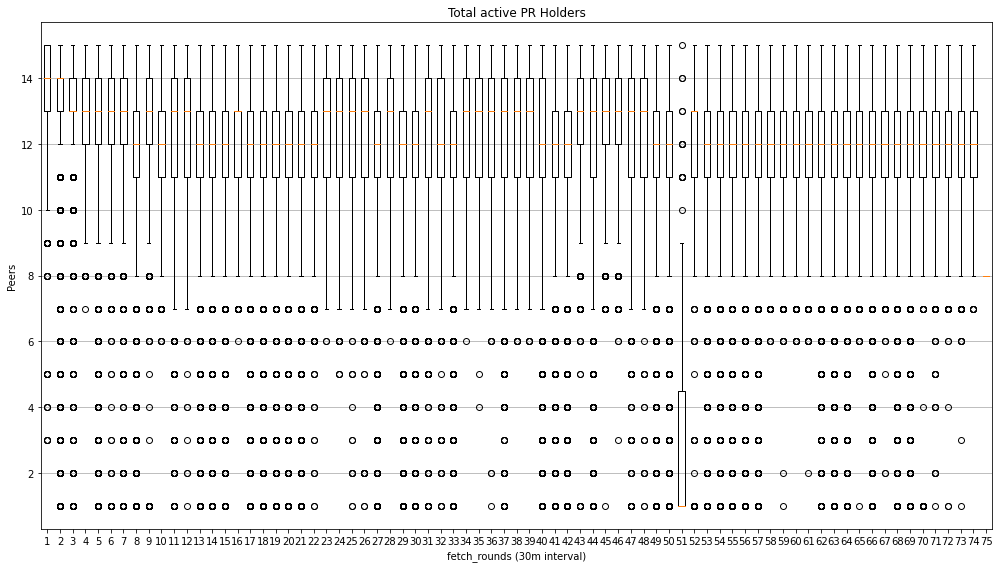

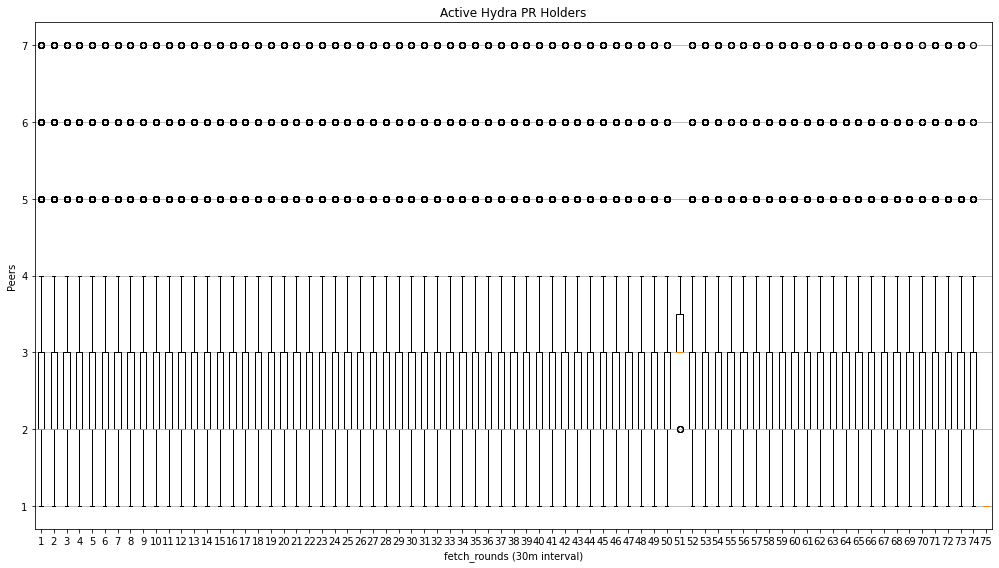

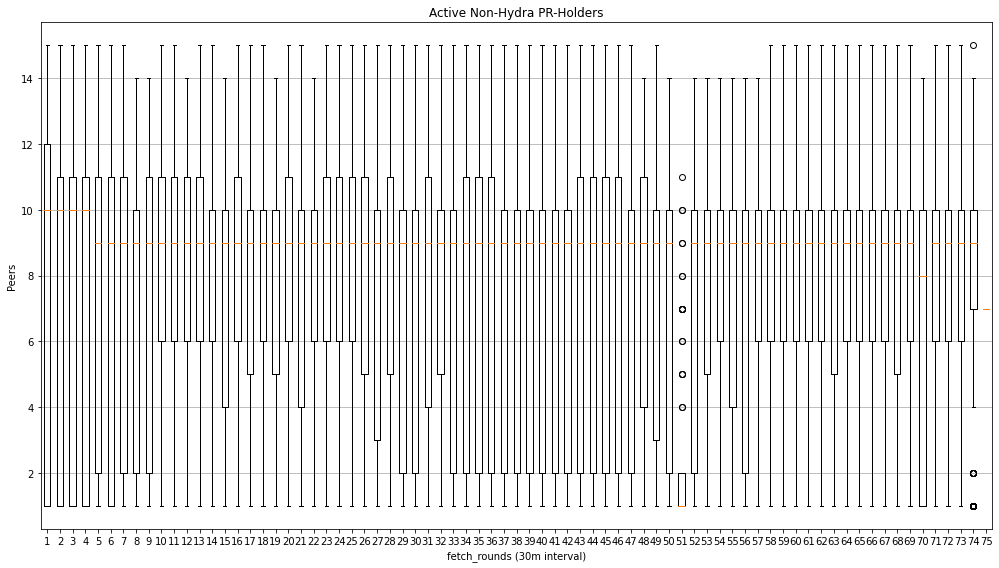

In [20]:
# Get active PR holders over fetch rounds hydra peers

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true 
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, p.client, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round, p.client order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, p.client, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round, p.client order by ping_round ASC;
    """,
]
title_set = ["Total active PR Holders", "Active Hydra PR Holders", "Active Non-Hydra PR-Holders"]

for item, query_item in enumerate(query_set):
    active_tot = []
    # Iterate through ping rounds to get 
    for idx, row in ping_rounds.iterrows():
        aux_act = []
        active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), db_con)
        for i, r in active_p.iterrows():
            aux_act.append(r['count'])
        active_tot.append(aux_act)

    # active hydras vs active no hydras
    fig, ax = plt.subplots()
    ax.boxplot(active_tot, showfliers=True) 
    ax.set_title(title_set[item])
    ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
    ax.set_ylabel("Peers")
    ax.figure.set_size_inches(14, 8)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

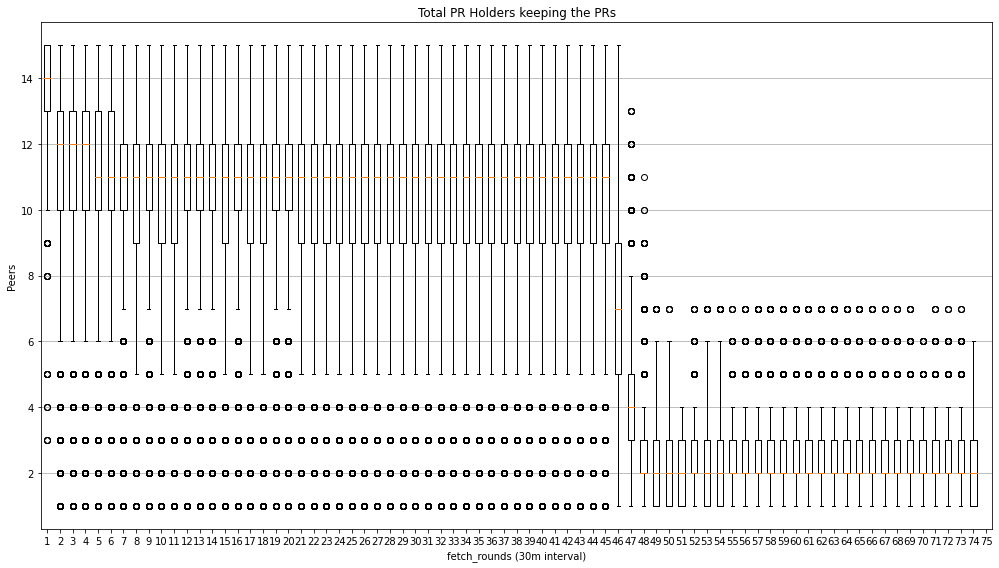

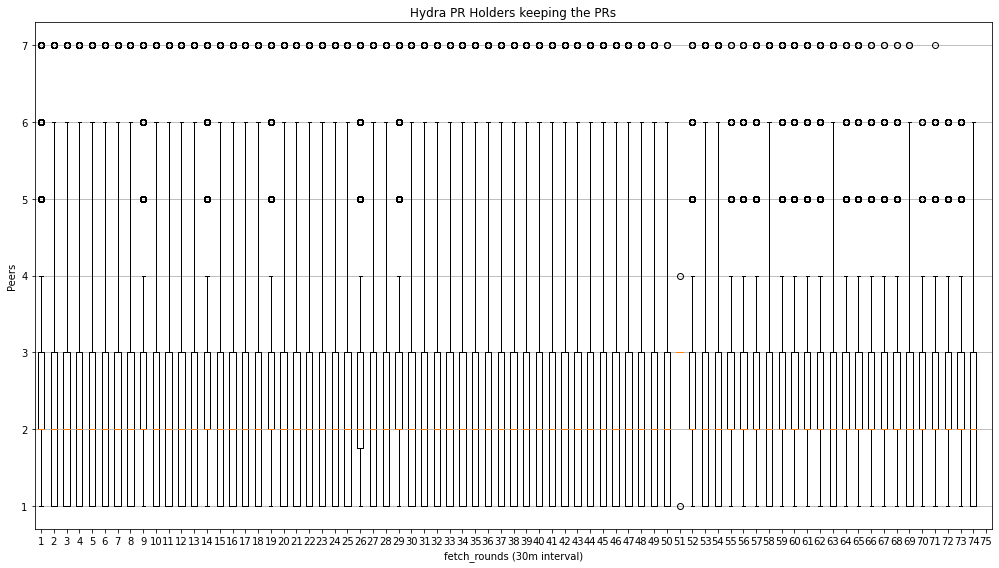

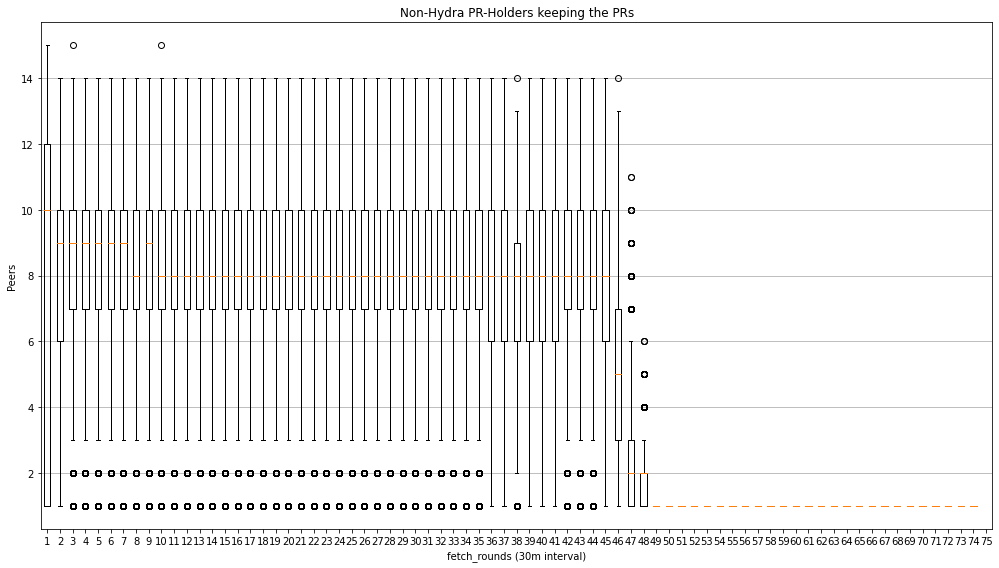

In [21]:
# Get PR holders keeping the PRs over fetch rounds

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true 
    group by p.cid_hash, p.ping_round order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, p.client, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round, p.client order by ping_round ASC;
    """,
    """
    select p.cid_hash, p.ping_round, p.client, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round, p.client order by ping_round ASC;
    """,
]

title_set = ["Total PR Holders keeping the PRs", "Hydra PR Holders keeping the PRs", "Non-Hydra PR-Holders keeping the PRs"]

for item, query_item in enumerate(query_set):
    active_tot = []
    # Iterate through ping rounds to get 
    for idx, row in ping_rounds.iterrows():
        aux_act = []
        active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), db_con)
        for i, r in active_p.iterrows():
            aux_act.append(r['count'])
        active_tot.append(aux_act)

    # active hydras vs active no hydras
    fig, ax = plt.subplots()
    ax.boxplot(active_tot, showfliers=True) 
    ax.set_title(title_set[item])
    ax.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
    ax.set_ylabel("Peers")
    ax.figure.set_size_inches(14, 8)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

          client  count  client percentage
0        go-ipfs   9868          65.476743
1  NotIdentified   2841          18.850773
2  hydra-booster   2034          13.496118
3          storm    230           1.526110
4         Others     61           0.404751
5            ioi     37           0.245505


Text(0.5, 1.0, 'Client type on PR Holders')

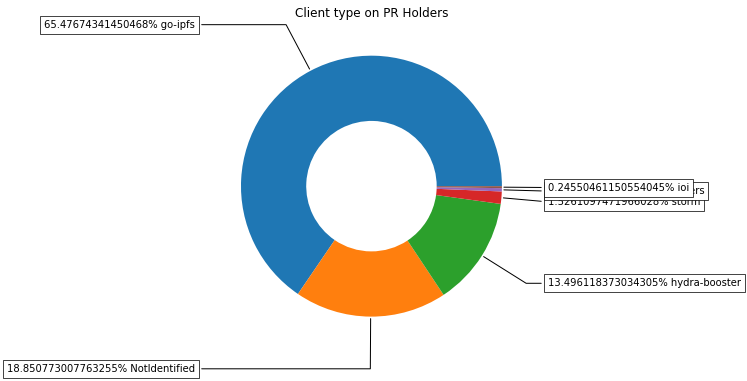

In [22]:
# Get client distribution on PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client percentage"] = (pobj["count"] * 100) / total
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client percentage"]}% {row["client"]}'
    labels.append(r)
    
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(pobj['client percentage'], wedgeprops=dict(width=0.5))#, startangle=-40)

# Generate the text boxes with the legend and percentajes 
bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Client type on PR Holders")


          client  count  client_ratio
0        go-ipfs   9868        0.9868
1  NotIdentified   2841        0.2841
2  hydra-booster   2034        0.2034
3          storm    230        0.0230
4         Others     61        0.0061
5            ioi     37        0.0037


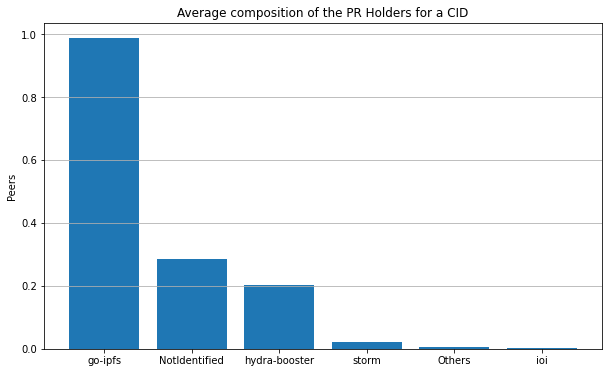

In [23]:
# Get number of Hyda boosters as PR Holders
pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", db_con)

total = 0
for i, c in pobj.iterrows():
    total += c["count"]
    
# get the percentage of each client
pobj["client_ratio"] = (pobj["count"]) / len(cids)
print(pobj)

# compose labels
labels = []
for i, row in pobj.iterrows():
    r = f'{row["client_ratio"]}% {row["client"]}'
    labels.append(r)

plt.bar(pobj['client'], pobj['client_ratio'])
plt.title("Average composition of the PR Holders for a CID")
plt.ylabel("Peers")
plt.grid(axis='y')
    

Text(0.5, 1.0, 'Error distribution over fetch rounds')

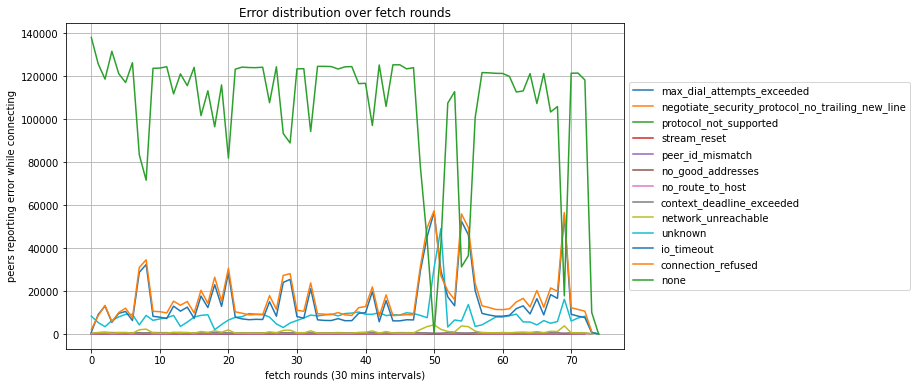

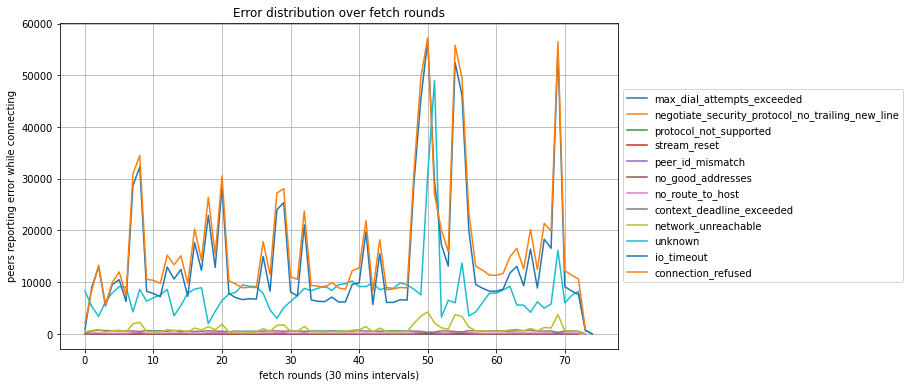

In [24]:
# Check the error getting connecting PR Holders

# get cids
cidobj = pd.read_sql_query('select id, cid_hash from cid_info', db_con)

# get list of errors from the entire pings
errorsobj = pd.read_sql_query('select conn_error, count(conn_error) from ping_results group by conn_error order by count(conn_error)', db_con)

pingsobj = pd.read_sql_query("select ping_round from ping_results group by ping_round order by ping_round ASC", db_con)

err_dist = {}
for i, r in errorsobj.iterrows():
    err_dist[r['conn_error']] = []
    
for i, r in pingsobj.iterrows():
    errorsobj = pd.read_sql_query(f'select conn_error, count(conn_error) from ping_results where ping_round={r["ping_round"]} group by conn_error order by count(conn_error) ASC', db_con)
    for idx, row in errorsobj.iterrows():
        err_dist[row["conn_error"]].append(row["count"])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for k in err_dist:
    ax.plot(err_dist[k], label=k)
    
ax.set_xlabel('fetch rounds (30 mins intervals)')
ax.set_ylabel('peers reporting error while connecting')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.title('Error distribution over fetch rounds')


    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for k in err_dist:
    if k == 'none':
        continue
    ax.plot(err_dist[k], label=k)
    
ax.set_xlabel('fetch rounds (30 mins intervals)')
ax.set_ylabel('peers reporting error while connecting')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.title('Error distribution over fetch rounds')    
    
